In [ ]:
!pip install osmnx


In [ ]:
import osmnx as ox
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from shapely.geometry import Point, LineString
import geopandas as gpd
from scipy.spatial import cKDTree

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Berlin2Pos.csv to Berlin2Pos.csv
Saving Berlin2VEL.csv to Berlin2VEL.csv


In [ ]:
import pandas as pd

# Load the POS and VEL files
pos_file_path = 'Berlin1VEL.csv'
vel_file_path = 'Brelin1POS.csv'
pos2_file_path = 'Berlin2Pos.csv'
vel2_file_path = 'Berlin2VEL.csv'

# Replace with the actual paths to your CSV files
pos_data = pd.read_csv(pos_file_path,delimiter=';')
vel_data = pd.read_csv(vel_file_path,delimiter=';')
pos2_data = pd.read_csv(pos2_file_path,delimiter=';')
vel2_data = pd.read_csv(vel2_file_path,delimiter=';')

# Display the first few rows of each file to understand their structure
# print("POS Data:")
# print(pos_data.columns)

# print("\nVEL Data:")
# print(vel_data.columns)


In [ ]:
# Use the exact column names for the merge
merged_data = pd.merge(pos_data, vel_data, on=['GPSWeek [weeks]', 'GPSSecondsOfWeek [s]'])
merged_data2 = pd.merge(pos2_data, vel2_data, on=['GPSWeek [weeks]', 'GPSSecondsOfWeek [s]'])

# Display the first few rows of the merged data to verify the merge
print("Merged Data:")
print(merged_data.head())


Merged Data:
   GPSWeek [weeks]  GPSSecondsOfWeek [s]  Solution status (sol status)  \
0             1900             126639.60                             0   
1             1900             126639.65                             0   
2             1900             126639.70                             0   
3             1900             126639.75                             0   
4             1900             126639.80                             0   

   Velocity type (vel type)  \
0                        56   
1                        56   
2                        56   
3                        56   
4                        56   

   A measure of the latency in the velocity time tag in seconds. It should be subtracted from the time to give improved results. (latency) [s]  \
0                                                0.0                                                                                             
1                                                0.0           

In [ ]:
# Drop unnecessary columns from the merged dataset
columns_to_keep = [
    'GPSWeek [weeks]', 'GPSSecondsOfWeek [s]',  # Common columns
    'Latitude (lat) [deg]', 'Longitude (lon) [deg]',  # From VEL file
    'Height above mean sea level (hgt) [m]',  # From VEL file
    'Horizontal speed over ground (hor spd) [m/s]',  # From POS file
    'Actual direction of motion over ground (track over ground) with respect to True North [deg]'  # From POS file
]


merged_data = merged_data[columns_to_keep]
merged_data2 = merged_data2[columns_to_keep]

# Optionally, rename columns for simplicity
merged_data.columns = ['GPSWeek', 'GPSSecondsOfWeek', 'Latitude', 'Longitude', 'Height', 'Speed', 'Direction']
merged_data2.columns = ['GPSWeek', 'GPSSecondsOfWeek', 'Latitude', 'Longitude', 'Height', 'Speed', 'Direction']
# Display the first few rows of the cleaned data
print("\nCleaned Merged Data:")
print(merged_data.head())



Cleaned Merged Data:
   GPSWeek  GPSSecondsOfWeek   Latitude  Longitude     Height     Speed  \
0     1900         126639.60  52.504485  13.373619  36.351531  3.876900   
1     1900         126639.65  52.504486  13.373619  36.353357  3.912439   
2     1900         126639.70  52.504488  13.373620  36.355648  3.944191   
3     1900         126639.75  52.504490  13.373621  36.357892  3.968345   
4     1900         126639.80  52.504491  13.373622  36.360129  3.988318   

   Direction  
0  14.851622  
1  15.006523  
2  15.325177  
3  15.817349  
4  16.181190  


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic

def stratified_sampling(data, num_samples=1200):
    """
    Performs stratified sampling on the dataset to maintain the distribution of points
    along the path while reducing the number of data points to the specified number.
    :param data: DataFrame containing GNSS data with 'Latitude' and 'Longitude' columns.
    :param num_samples: Desired number of samples in the final trimmed dataset.
    :return: Stratified sampled DataFrame with the specified number of data points.
    """

    # Drop rows with NaN values in Latitude and Longitude
    data = data.dropna(subset=['Latitude', 'Longitude'])

    # Calculate cumulative distance along the path
    data['cumulative_distance'] = 0.0
    for i in range(1, len(data)):
        prev_point = (data.iloc[i-1]['Latitude'], data.iloc[i-1]['Longitude'])
        current_point = (data.iloc[i]['Latitude'], data.iloc[i]['Longitude'])
        distance = geodesic(prev_point, current_point).meters
        data.at[i, 'cumulative_distance'] = data.at[i-1, 'cumulative_distance'] + distance

    # Normalize cumulative distance to range [0, 1] for stratified sampling
    data['cumulative_distance_normalized'] = data['cumulative_distance'] / data['cumulative_distance'].max()

    # Perform stratified sampling
    bins = np.linspace(0, 1, num_samples)
    data['bin'] = pd.cut(data['cumulative_distance_normalized'], bins, include_lowest=True)
    sampled_data = data.groupby('bin').apply(lambda x: x.sample(1) if len(x) > 0 else x.head(1)).reset_index(drop=True)


    # Sort the sampled data by the original index to maintain the sequence
    sampled_data = sampled_data.sort_index()

    # Drop helper columns
    sampled_data = sampled_data.drop(columns=['cumulative_distance', 'cumulative_distance_normalized', 'bin'])

    return sampled_data.reset_index(drop=True)

# Apply stratified sampling to both datasets
merged_data_trimmed = stratified_sampling(merged_data, num_samples=1200)
merged_data2_trimmed = stratified_sampling(merged_data2, num_samples=1200)

# Display the number of rows before and after trimming
print(f"Original merged_data rows: {len(merged_data)}")
print(f"Trimmed merged_data rows: {len(merged_data_trimmed)}")
print(f"Original merged_data2 rows: {len(merged_data2)}")
print(f"Trimmed merged_data2 rows: {len(merged_data2_trimmed)}")

merged_data = merged_data_trimmed
merged_data2 = merged_data2_trimmed

# Optional: Save the trimmed datasets to new CSV files
# merged_data.to_csv('merged_data_trimmed.csv', index=False)
# merged_data2.to_csv('merged_data2_trimmed.csv', index=False)

<ipython-input-215-57603f6e4e74>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_data = data.groupby('bin').apply(lambda x: x.sample(1) if len(x) > 0 else x.head(1)).reset_index(drop=True)
<ipython-input-215-57603f6e4e74>:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_data = data.groupby('bin').apply(lambda x: x.sample(1) if len(x) > 0 else x.head(1)).reset_index(drop=True)


Original merged_data rows: 5721
Trimmed merged_data rows: 1199
Original merged_data2 rows: 23975
Trimmed merged_data2 rows: 1138


In [ ]:
import pandas as pd

# Ensure merged_data has the same number of rows as merged_data2
if len(merged_data) > len(merged_data2):
    merged_data = merged_data.sample(n=len(merged_data2), random_state=42).reset_index(drop=True)
elif len(merged_data2) > len(merged_data):
    merged_data2 = merged_data2.sample(n=len(merged_data), random_state=42).reset_index(drop=True)

# Display the number of rows after adjustment
print(f"Adjusted merged_data rows: {len(merged_data)}")
print(f"Adjusted merged_data2 rows: {len(merged_data2)}")

print(merged_data.columns)

# Optional: Save the adjusted datasets to new CSV files
# merged_data.to_csv('merged_data_adjusted.csv', index=False)
# merged_data2.to_csv('merged_data2_adjusted.csv', index=False)


Adjusted merged_data rows: 1138
Adjusted merged_data2 rows: 1138
Index(['GPSWeek', 'GPSSecondsOfWeek', 'Latitude', 'Longitude', 'Height',
       'Speed', 'Direction', 'unique_id'],
      dtype='object')


52.5166037747016 52.504159753526295 13.371699535702701 13.3969483095341
Bounding box: North: 52.5166037747016, South: 52.504159753526295, East: 13.3969483095341, West: 13.371699535702701


<ipython-input-283-05b882e47ee0>:27: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')
<ipython-input-283-05b882e47ee0>:27: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = ox.graph_from_bbox(north, south, east, west, network_type='drive')


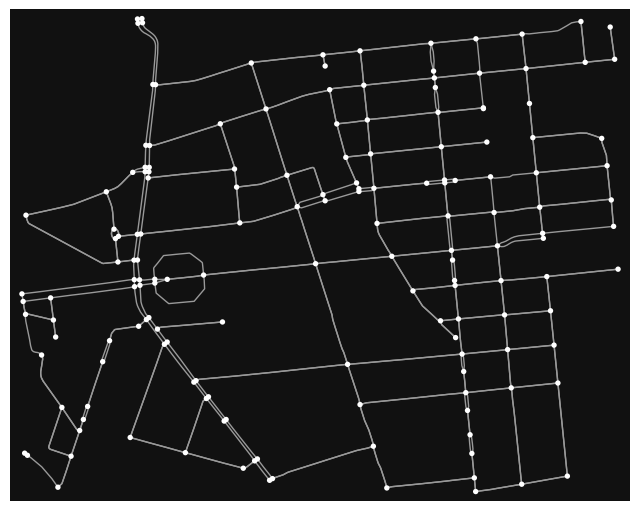

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [ ]:
import pandas as pd
import osmnx as ox

# Assuming merged_data and merged_data2 are already available from the previous steps

# Combine the datasets to calculate the bounding box
combined_data = pd.concat([merged_data, merged_data2])

# Calculate the minimum and maximum latitude and longitude
min_latitude = combined_data['Latitude'].min()
max_latitude = combined_data['Latitude'].max()
min_longitude = combined_data['Longitude'].min()
max_longitude = combined_data['Longitude'].max()

# Expand the bounding box slightly (e.g., by 0.01 degrees)
expand_factor = 0.0003
north = max_latitude + expand_factor
south = min_latitude - expand_factor
east = max_longitude + expand_factor
west = min_longitude - expand_factor
print(north, south, west, east)

# Print the bounding box for reference
print(f"Bounding box: North: {north}, South: {south}, East: {east}, West: {west}")

# Use OSMnx to get the road network within the bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Optionally, save the graph to a file for later use
ox.save_graphml(G, 'road_network.graphml')

# Plot the graph to verify
ox.plot_graph(G)


In [ ]:
def add_unique_ids_to_edges(graph):
    """
    Adds a unique ID to each edge in the graph.
    :param graph: The OSMnx graph.
    :return: The graph with unique IDs added to each edge.
    """
    for i, (u, v, key) in enumerate(graph.edges(keys=True)):
        graph[u][v][key]['unique_id'] = i
        print(graph[u][v][key]['unique_id'])
    return graph

print(len(G.edges(keys=True)))
# Apply unique IDs to edges in the graph
G = add_unique_ids_to_edges(G)

411
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [ ]:
print()

In [ ]:
def find_nearest_edges_with_ids(graph, data):
    """
    Finds the nearest edge for each GNSS point in the dataset and adds the edge's unique ID to the DataFrame.
    :param graph: The OSMnx graph.
    :param data: DataFrame containing GNSS data with 'Latitude' and 'Longitude' columns.
    :return: The DataFrame with a new column 'unique_id' for the nearest edge.
    """
    unique_ids = []
    for idx, row in data.iterrows():
        # Find the nearest edge
        nearest_edge = ox.distance.nearest_edges(graph, X=row['Longitude'], Y=row['Latitude'])
        u, v, key = nearest_edge

        # Get the unique ID of the nearest edge
        unique_id = graph[u][v][key]['unique_id']
        unique_ids.append(unique_id)

    # Add the unique ID column to the DataFrame
    data['unique_id'] = unique_ids

    return data

# Apply the function to both datasets
merged_data = find_nearest_edges_with_ids(G, merged_data)
merged_data2 = find_nearest_edges_with_ids(G, merged_data2)

In [ ]:
merged_data.head()


,GPSWeek,GPSSecondsOfWeek,Latitude,Longitude,Height,Speed,Direction,unique_id
0,1900,126921.05,52.504688,13.373710,39.465353,8.344459,198.421507,201
1,1900,126858.50,52.507879,13.373081,36.122251,6.939001,232.137630,410
2,1900,126673.10,52.505276,13.373023,37.369033,4.229283,319.315616,200
3,1900,126745.30,52.508678,13.372318,37.106813,6.755925,99.894073,224
4,1900,126652.95,52.505115,13.373812,36.843716,4.130819,293.002632,200


In [ ]:
print(nearest_edges_1)

[(26746046, 26746053, 0), (26746046, 26746053, 0), (26746046, 26746053, 0), (26746053, 26746046, 0), (26746046, 26746053, 0), (26746046, 26746053, 0), (26746053, 26746046, 0), (26746046, 26746053, 0), (26746053, 26746046, 0), (26746053, 26746046, 0), (26746053, 26746046, 0), (26746046, 26746053, 0), (26746053, 26746046, 0), (26746053, 26746046, 0), (26746032, 26746046, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746032, 26746046, 0), (26746032, 26746046, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746032, 26746046, 0), (26746046, 26746032, 0), (26746032, 26746046, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746032, 26746046, 0), (26746032, 26746046, 0), (26746032, 26746046, 0), (26746032, 26746046, 0), (26746032, 26746046, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746046, 26746032, 0), (26746032, 26746046, 0), (26746032, 26746046, 0),

In [ ]:
# import pandas as pd
# import osmnx as ox
# import networkx as nx
# import matplotlib.pyplot as plt
# from shapely.geometry import LineString

# Step 2: Plot the Paths on the OSMnx Map

def plot_paths(graph, edges, color_x):
    # Plot the graph
    fig, ax = ox.plot_graph(graph, show=False, close=False)

    # Function to get the geometry of an edge
    def get_edge_geometry(graph, u, v, key):
        if 'geometry' in graph[u][v][key]:
            return graph[u][v][key]['geometry']
        else:
            # Create a straight line if no geometry is present
            return LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),
                               (graph.nodes[v]['x'], graph.nodes[v]['y'])])

    # Plot the path for the first dataset (blue)
    for edge in edges:
        u, v, key = edge
        edge_geom = get_edge_geometry(graph, u, v, key)
        ax.plot(edge_geom.xy[0], edge_geom.xy[1], color=color_x, alpha=0.7, linewidth=2, label='Dataset 1' if edge == edges[0] else "")

    # Plot the path for the second dataset (red)
    # for edge in edges_2:
    #     u, v, key = edge
    #     edge_geom = get_edge_geometry(graph, u, v, key)
    #     ax.plot(edge_geom.xy[0], edge_geom.xy[1], color='red', alpha=0.7, linewidth=2, label='Dataset 2' if edge == edges_2[0] else "")

    # Add a legend
    plt.show()


# Plot the paths on the map
plot_paths(G, nearest_edges_1, 'blue')
plot_paths(G, nearest_edges_2, 'red')


In [ ]:
import osmnx as ox
import random
import networkx as nx
from shapely.geometry import LineString

def find_parallel_roads(graph, num_highways=3, angle_tolerance=5, max_attempts=5):
    """
    Identifies sets of parallel roads in the graph.
    :param graph: The OSMnx graph.
    :param num_highways: Number of sets of parallel roads to designate as highways.
    :param angle_tolerance: Tolerance for considering roads as parallel (e.g., 5 degrees).
    :param max_attempts: Maximum attempts to find a parallel road set starting from different edges.
    :return: A list of sets of parallel roads.
    """
    edges = list(graph.edges(keys=True, data=True))
    parallel_road_sets = []

    def select_initial_edge(edges):
        """
        Selects an initial edge more likely to have parallel roads.
        :param edges: List of edges in the graph.
        :return: The selected initial edge.
        """
        return random.choice(edges)

    def get_bearing(u, v):
        """
        Calculates the bearing between two nodes.
        :param u: Starting node.
        :param v: Ending node.
        :return: Bearing angle in degrees.
        """
        lat1, lon1 = graph.nodes[u]['y'], graph.nodes[u]['x']
        lat2, lon2 = graph.nodes[v]['y'], graph.nodes[v]['x']
        return ox.bearing.calculate_bearing(lat1, lon1, lat2, lon2)

    def find_parallel_recursive(graph, edge, angle_range, visited):
        """
        Recursively finds parallel roads within a certain angle range.
        :param graph: The OSMnx graph.
        :param edge: Current edge to expand from.
        :param angle_range: Tuple defining the acceptable angle range (min_angle, max_angle).
        :param visited: Set of visited edge identifiers.
        :return: List of parallel roads.
        """
        u, v, key, data = edge
        edge_id = (u, v, key)  # Use only the unique identifiers (u, v, key) for tracking visited edges
        if edge_id in visited:
            return []

        visited.add(edge_id)
        parallel_roads = [edge]

        for neighbor in graph.edges(v, keys=True, data=True):
            nu, nv, nkey, ndata = neighbor
            neighbor_id = (nu, nv, nkey)
            if neighbor_id not in visited:
                bearing = get_bearing(v, nv)
                if angle_range[0] <= bearing <= angle_range[1]:
                    parallel_roads.extend(find_parallel_recursive(graph, neighbor, angle_range, visited))

        return parallel_roads

    for _ in range(num_highways):
        attempts = 0
        while attempts < max_attempts:
            # Select an initial edge in the center region
            initial_edge = select_initial_edge(edges)

            # Determine the bearing of the initial edge
            u, v, key, data = initial_edge
            initial_bearing = get_bearing(u, v)

            # Define the angle range for parallel roads
            angle_range = (initial_bearing - angle_tolerance, initial_bearing + angle_tolerance)

            # Find parallel roads starting from the initial edge
            visited = set()
            parallel_roads = find_parallel_recursive(graph, initial_edge, angle_range, visited)

            if len(parallel_roads) > 1:
                parallel_road_sets.append(parallel_roads)
                break  # Break out of the attempts loop if successful

            attempts += 1

    return parallel_road_sets

# Identify parallel roads
parallel_road_sets = find_parallel_roads(G, num_highways=4)  # Set 4 parallel road sets as highways


In [ ]:
def create_road_type_mapping(parallel_road_sets):
    road_type_mapping = {}
    for road_set in parallel_road_sets:
        for edge in road_set:
            u, v, key, properties = edge
            unique_id = properties['unique_id']
            road_type_mapping[unique_id] = 1  # Assign '1' for highways
    return road_type_mapping

# Assuming 'parallel_road_sets' is available from the find_parallel_roads function
road_type_mapping = create_road_type_mapping(parallel_road_sets)
print(road_type_mapping)


{399: 1, 391: 1, 278: 1, 87: 1, 83: 1, 89: 1, 280: 1, 350: 1, 6: 1, 180: 1, 15: 1, 18: 1, 149: 1, 141: 1, 144: 1, 212: 1}


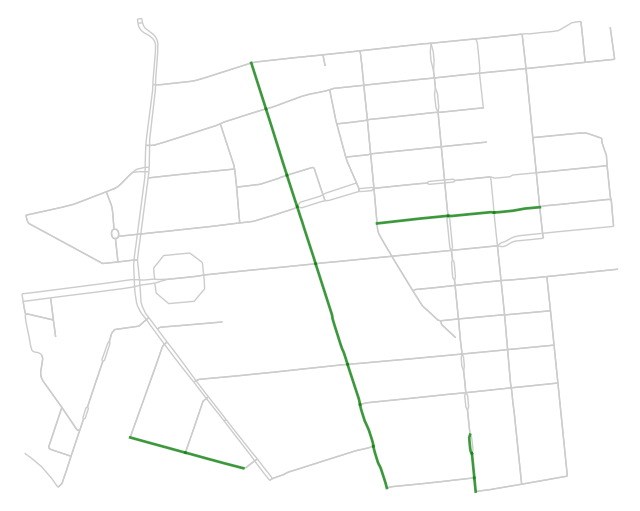

In [ ]:
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import LineString

def plot_parallel_roads(graph, parallel_road_sets):
    """
    Plots the identified parallel road sets on the OSMnx graph.
    Highlights the parallel roads in green.
    :param graph: The OSMnx graph.
    :param parallel_road_sets: List of sets of parallel roads to visualize.
    """
    # Plot the base graph
    fig, ax = ox.plot_graph(graph, show=False, close=False, bgcolor='w', node_size=0, edge_color='#cccccc')

    # Color each set of parallel roads in green
    for road_set in parallel_road_sets:
        for u, v, key, data in road_set:
            if 'geometry' in data:
                line = data['geometry']
            else:
                line = LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),
                                   (graph.nodes[v]['x'], graph.nodes[v]['y'])])
            x, y = line.xy
            ax.plot(x, y, color='green', linewidth=2, alpha=0.7)

    # Show the plot
    plt.show()

# Plot the parallel roads
plot_parallel_roads(G, parallel_road_sets)


In [ ]:
!pip install spektral

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate, Reshape
from tensorflow.keras.models import Model

# Number of unique road segments (based on your preprocessed data)
num_segments = len(G.edges)

# Define the LSTM-based Model
def build_lstm_model(sequence_length, num_features, num_segments):
    # LSTM input shape
    lstm_input = Input(shape=(sequence_length, num_features), name='lstm_input')

    # LSTM Layer
    lstm_out = LSTM(32, return_sequences=False)(lstm_input)

    # Segment ID input shape
    segment_input = Input(shape=(1,), dtype='int32', name='segment_input')
    segment_embedding = Embedding(input_dim=num_segments, output_dim=16)(segment_input)
    # Reshape layer to remove the extra dimension
    segment_embedding = Reshape((16,))(segment_embedding)

    # Road type input shape (highway or service road)
    road_type_input = Input(shape=(1,), dtype='int32', name='road_type_input')
    road_type_embedding = Embedding(input_dim=2, output_dim=4)(road_type_input)
    # Reshape layer to remove the extra dimension
    road_type_embedding = Reshape((4,))(road_type_embedding)

    # Combine LSTM output with Segment Embedding and Road Type Embedding
    combined = Concatenate()([lstm_out, segment_embedding, road_type_embedding])

    # Dense Layer to predict the next road segment
    output = Dense(num_segments, activation='softmax', name='output')(combined)

    # Define the model
    model = Model(inputs=[lstm_input, segment_input, road_type_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

# Build the model
sequence_length = 2  # This can be adjusted based on your data
gnss_features = ['Latitude', 'Longitude', 'Speed', 'Bearing']  # Define your GNSS features
num_features = len(gnss_features)  # Number of features in GNSS data (e.g., Latitude, Longitude, Speed)
model = build_lstm_model(sequence_length, num_features, num_segments)

# Print the model summary
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ segment_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ road_type_input           │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_input (InputLayer)   │ (None, 2, 4)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_33 (Embedding)  │ (None, 1, 16)          │          6,576 │ segment_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_34 (Embedding)  │ (None, 1, 4)           │              8 │ road_type_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_21 (LSTM)            │ (None, 32)             │          4,736 │ lstm_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_25 (Reshape)      │ (None, 16)             │              0 │ embedding_33[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_26 (Reshape)      │ (None, 4)              │              0 │ embedding_34[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 52)             │              0 │ lstm_21[0][0],         │
│ (Concatenate)             │                        │                │ reshape_25[0][0],      │
│                           │                        │                │ reshape_26[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 411)            │         21,783 │ concatenate_14[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 33,103 (129.31 KB)

 Trainable params: 33,103 (129.31 KB)

 Non-trainable params: 0 (0.00 B)

[(20246257, 25662542, 0), (20246257, 25662705, 0), (20246257, 2071423335, 0), (25661285, 26870585, 0), (25661285, 25661287, 0), (25661285, 3463621768, 0), (25661287, 26708008, 0), (25661287, 25661289, 0), (25661287, 25661285, 0), (25661289, 25662542, 0), (25661289, 25661287, 0), (25661289, 545164353, 0), (25661366, 25661991, 0), (25661366, 25661976, 0), (25661366, 26708008, 0), (25661366, 25661372, 0), (25661372, 271747430, 0), (25661372, 25661984, 0), (25661372, 25663498, 0), (25661372, 25661366, 0), (25661386, 25661966, 0), (25661386, 25662916, 0), (25661386, 25662542, 0), (25661386, 25661963, 0), (25661963, 26708008, 0), (25661963, 25661386, 0), (25661963, 262480689, 0), (25661966, 25662928, 0), (25661966, 262480689, 0), (25661966, 25661967, 0), (25661966, 25661386, 0), (25661967, 25662931, 0), (25661967, 25661966, 0), (25661967, 25662047, 0), (25661967, 25661969, 0), (25661969, 10287240230, 0), (25661969, 960119785, 0), (25661969, 25662041, 0), (25661969, 25661967, 0), (25661976, 2

In [ ]:
import numpy as np

# Define the GNSS features based on your dataset
gnss_features = ['Latitude', 'Longitude', 'Speed', 'Direction']  # Adjusted to remove 'Bearing'

# Prepare input sequences and segment IDs
def prepare_model_inputs(data, road_type_mapping, sequence_length=2):
    X_gnss, X_segments, X_road_type, y_segments = [], [], [], []
    for i in range(len(data) - sequence_length):
        # GNSS data sequence
        gnss_seq = data.iloc[i:i+sequence_length][gnss_features].values
        X_gnss.append(gnss_seq)

        # Current road segment and road type (we use the segment at the start of the sequence)
        current_segment = data.iloc[i]['unique_id']

        # Determine road type based on the mapping
        current_road_type = road_type_mapping.get(current_segment, 0)  # Default to 0 if not found

        X_segments.append(current_segment)
        X_road_type.append(current_road_type)

        # Target: the road segment ID of the next GNSS point
        next_segment = data.iloc[i+sequence_length]['unique_id']
        y_segments.append(next_segment)

    return np.array(X_gnss), np.array(X_segments), np.array(X_road_type), np.array(y_segments)

# Prepare inputs for both datasets
X1_gnss, X1_segments, X1_road_type, y1_segments = prepare_model_inputs(merged_data, road_type_mapping)
X2_gnss, X2_segments, X2_road_type, y2_segments = prepare_model_inputs(merged_data2, road_type_mapping)


# Prepare inputs for both datasets
# X1_gnss, X1_segments, X1_road_type, y1_segments = prepare_model_inputs(merged_data)
print(X1_gnss)
# X2_gnss, X2_segments, X2_road_type, y2_segments = prepare_model_inputs(merged_data2)

[[[ 52.50468839  13.37371032   8.34445923 198.42150715]
  [ 52.50787852  13.37308051   6.93900137 232.13763019]]

 [[ 52.50787852  13.37308051   6.93900137 232.13763019]
  [ 52.50527611  13.37302292   4.22928289 319.3156159 ]]

 [[ 52.50527611  13.37302292   4.22928289 319.3156159 ]
  [ 52.50867774  13.37231795   6.75592528  99.89407308]]

 ...

 [[ 52.50822121  13.37383968   6.35270947 232.94019081]
  [ 52.50704025  13.37270587   5.63650035 322.52043857]]

 [[ 52.50704025  13.37270587   5.63650035 322.52043857]
  [ 52.50656261  13.37322565   7.53968213 145.74796027]]

 [[ 52.50656261  13.37322565   7.53968213 145.74796027]
  [ 52.50638345  13.37345408   6.50574386 331.37066737]]]


In [ ]:
# Build the model
model = build_lstm_model(sequence_length, num_features, num_segments)

# Train the model
history1 = model.fit(
    [X1_gnss, X1_segments, X1_road_type],
    y1_segments,
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_split=0.2  # Adjust based on your requirements
)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0131 - loss: 5.9515 - val_accuracy: 0.0395 - val_loss: 5.6265
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0622 - loss: 5.4728 - val_accuracy: 0.1930 - val_loss: 4.8035
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1589 - loss: 4.4526 - val_accuracy: 0.1974 - val_loss: 3.3012
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1665 - loss: 3.0481 - val_accuracy: 0.2193 - val_loss: 2.6501
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2223 - loss: 2.6314 - val_accuracy: 0.2193 - val_loss: 2.5628
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2273 - loss: 2.5402 - val_accuracy: 0.2193 - val_loss: 2.5360
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2468 - loss: 2.5058 - val_accuracy: 0.2193 - val_loss: 2.5275
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2185 - loss: 2.4996 - val_accuracy: 0.2193 - val_loss

In [ ]:
# Save the model weights using the correct filename format
model.save_weights('model_weights.weights.h5')

In [ ]:
# Build the model again
model = build_lstm_model(sequence_length, num_features, num_segments)

# Load the previously saved weights
model.load_weights('model_weights.weights.h5')

# Continue training on the second dataset
history2 = model.fit(
    [X2_gnss, X2_segments, X2_road_type],
    y2_segments,
    epochs=10,  # Adjust based on your requirements
    batch_size=32,  # Adjust based on your requirements
    validation_split=0.2  # Adjust based on your requirements
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.0000e+00 - loss: 8.9677 - val_accuracy: 0.0000e+00 - val_loss: 7.3845
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 5.9367 - val_accuracy: 0.0000e+00 - val_loss: 5.8874
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 5.2016 - val_accuracy: 0.0000e+00 - val_loss: 5.9004
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0016 - loss: 4.6575 - val_accuracy: 0.0000e+00 - val_loss: 5.9554
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0666 - loss: 4.1775 - val_accuracy: 0.0000e+00 - val_loss: 5.9840
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1409 - loss: 3.8373 - val_accuracy: 0.0000e+00 - val_loss: 6.0812
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1161 - loss: 3.6209 - val_accuracy: 0.0000e+00 - val_loss: 6.2199
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1319 - loss: 3.3832 - va

In [ ]:
tempd = pd.read_csv('firstDataBerlin.csv',delimiter=',')
tempd.head

<bound method NDFrame.head of        Latitude  Longitude      Height      Speed   Direction
0     52.506565  13.390456   43.674406  59.125775   93.464866
1     52.506564  13.390702   46.135478  60.000000   90.625683
2     52.506586  13.390945   43.716297  60.000000   81.428003
3     52.506610  13.391188   47.047818  60.000000   80.664356
4     52.506653  13.391415   46.777109  58.063360   72.838043
...         ...        ...         ...        ...         ...
1995  52.514918  13.378331 -261.204305  55.668630  241.191103
1996  52.514855  13.378120 -256.871601  57.233607  244.173532
1997  52.514797  13.377927 -258.518876  52.373280  243.523976
1998  52.514733  13.377738 -254.712765  52.858574  240.743591
1999  52.514652  13.377564 -258.357875  53.397598  232.741371

[2000 rows x 5 columns]>

In [ ]:
print(tempd.columns)
print(tempd['Latitude'])

Index(['Latitude', 'Longitude', 'Height', 'Speed', 'Direction'], dtype='object')
0       52.506565
1       52.506564
2       52.506586
3       52.506610
4       52.506653
          ...    
1995    52.514918
1996    52.514855
1997    52.514797
1998    52.514733
1999    52.514652
Name: Latitude, Length: 2000, dtype: float64


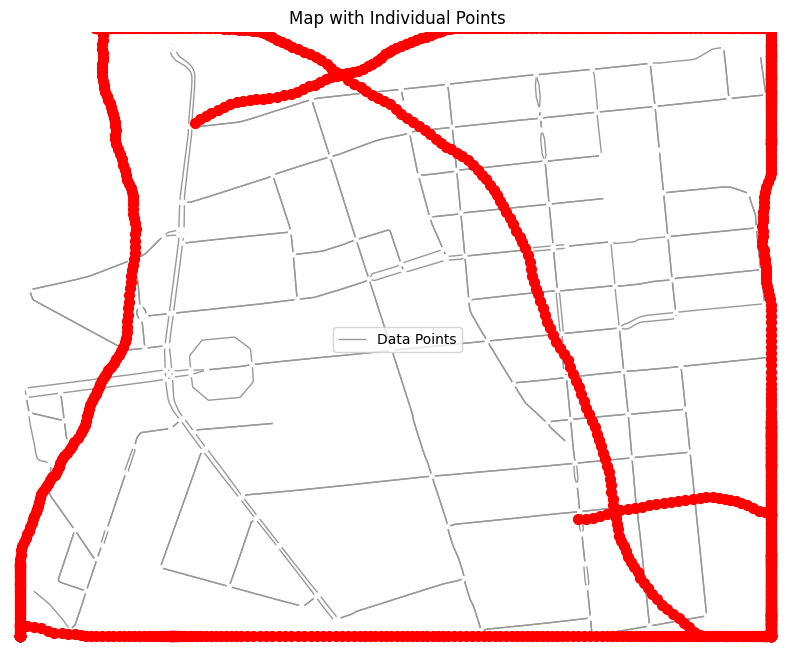

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, show=False, close=False)

# Plot each individual point from tempd
for _, p in tempd.iterrows():
    ax.scatter(p['Longitude'], p['Latitude'], color='red', s=50)

# Add a legend
ax.legend(['Data Points'])

# Add title and labels
plt.title('Map with Individual Points')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
import numpy as np

# Create dummy new data for prediction
dummy_data = {
    'segment_input': np.array([[1], [1]]),  # Example segment ID for each sample
    'road_type_input': np.array([[1], [1]]),  # Example road type for each sample
    'lstm_input': np.array([
        [[52.506, 13.391, 50.0, 90.0], [52.507, 13.392, 50.5, 91.0]],  # Example GNSS points for sample 1
        [[52.508, 13.393, 51.0, 92.0], [52.509, 13.394, 51.5, 93.0]]   # Example GNSS points for sample 2
    ])
}

# 52.5166037747016 52.504159753526295 13.371699535702701 13.3969483095341

# Predict using the model
predictions = model.predict([
    dummy_data['lstm_input'],
    dummy_data['segment_input'],
    dummy_data['road_type_input']
])

segoneProb = []
# Assuming `predictions` is a list of arrays with probabilities for each sample
for i, prediction in enumerate(predictions):
    # Get top 3 segment IDs with highest probabilities
    top_3_indices = np.argsort(prediction)[-3:]  # Sort and get top 3 indices
    top_3_probs = np.sort(prediction)[-3:]      # Sort and get top 3 probabilities #Removed [0] to look at the 1-d array

    print(f"Sample {i+1} - Top 3 Segment IDs and their Probabilities:")
    for idx, prob in zip(top_3_indices, top_3_probs):
        print(f"Segment ID: {idx}, Probability: {prob:.4f}")
        if i == 1:
          segoneProb.append(idx)

print(segoneProb)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sample 1 - Top 3 Segment IDs and their Probabilities:
Segment ID: 39, Probability: 0.0038
Segment ID: 219, Probability: 0.0041
Segment ID: 15, Probability: 0.0043
Sample 2 - Top 3 Segment IDs and their Probabilities:
Segment ID: 39, Probability: 0.0038
Segment ID: 219, Probability: 0.0041
Segment ID: 15, Probability: 0.0044
[39, 219, 15]


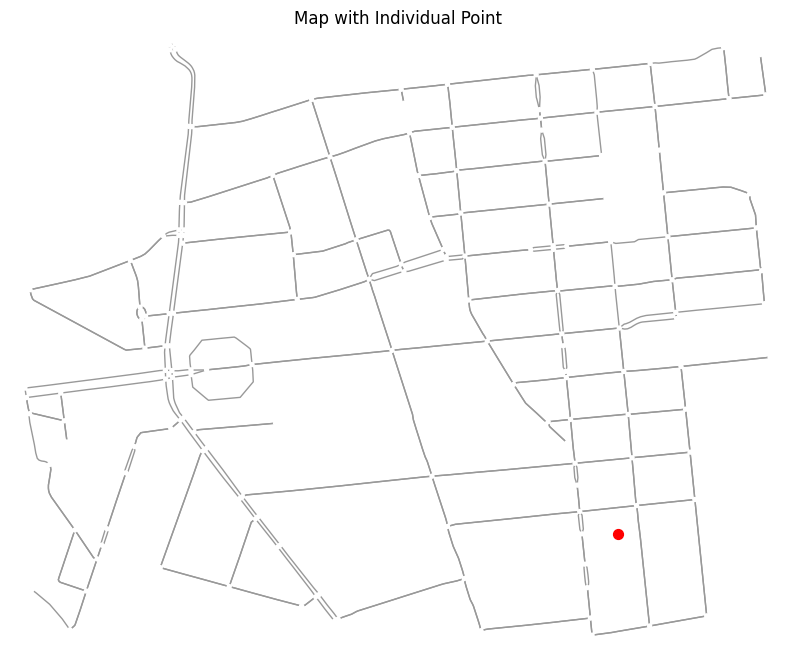

In [ ]:
import matplotlib.pyplot as plt
import osmnx as ox

# Plot the graph
fig, ax = plt.subplots(figsize=(10, 10))
ox.plot_graph(G, ax=ax, show=False, close=False)

# Coordinates for the individual point
longitude = 13.39178295825
latitude = 52.5062568420895

# Plot the individual point
ax.scatter(longitude, latitude, color='red', s=50, label='p1')

# Add a legend

# Add title and labels
plt.title('Map with Individual Point')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


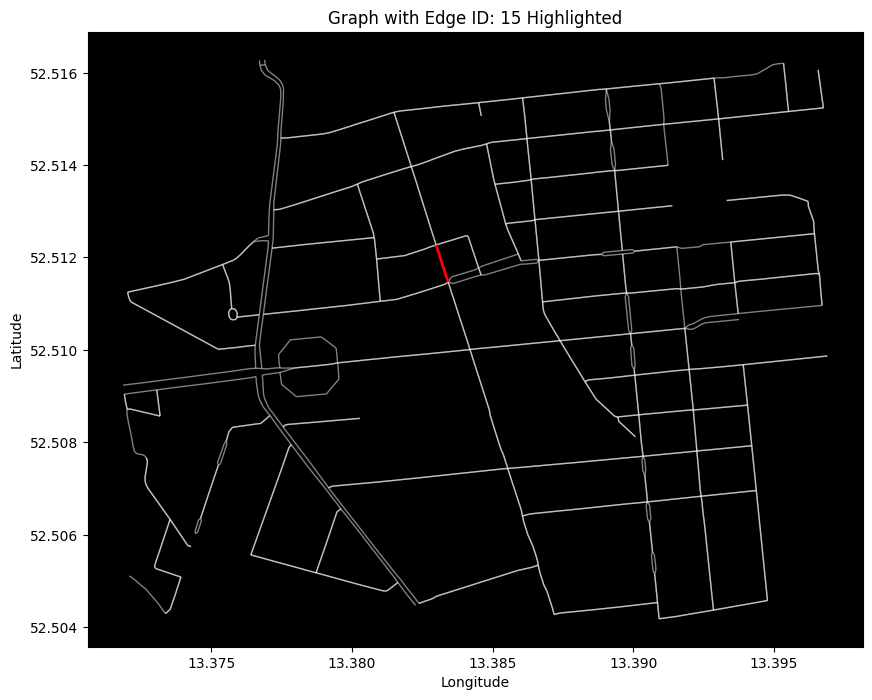

In [ ]:
def get_edge_by_id(graph, edge_id):
    """
    Find the edge with a given unique ID.
    :param graph: The OSMnx graph.
    :param edge_id: The unique ID of the edge.
    :return: The edge (u, v, key) if found, otherwise None.
    """
    for u, v, key in graph.edges(keys=True):
        # print(graph[u][v][key].get('unique_id'))
        if graph[u][v][key]['unique_id'] == edge_id:
            # print((u,v,key))
            return (u, v, key)
    return None



def extract_edge_coordinates(graph, edge):
    """
    Extract the coordinates of an edge.
    :param graph: The OSMnx graph.
    :param edge: The edge (u, v, key).
    :return: List of coordinates for the edge.
    """
    u, v, key = edge
    edge_data = graph.get_edge_data(u, v, key)
    coords = edge_data['geometry'].coords
    return list(coords)

import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString

def plot_edge_on_map(graph, highlight_edge_id):
    """
    Plot all edges of the graph with a specific edge highlighted in red.
    :param graph: The OSMnx graph.
    :param highlight_edge_id: The unique ID of the edge to highlight in red.
    """
    # Extract all edges
    edges = list(graph.edges(keys=True))
    edge_geometries = []

    for u, v, key in edges:
        if 'geometry' in graph[u][v][key]:
            edge_geometries.append((u, v, key, graph[u][v][key]['geometry']))

    # Create a GeoDataFrame for all edges
    all_edges_gdf = gpd.GeoDataFrame(geometry=[edge for _, _, _, edge in edge_geometries])
    all_edges_gdf.crs = "EPSG:4326"  # Coordinate reference system

    # Plot all edges
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('black')  # Set background color to black
    all_edges_gdf.plot(ax=ax, color='white', linewidth=1, alpha=0.5)  # Plot all edges in white

    # Highlight the specific edge
    highlight_edge = get_edge_by_id(graph, highlight_edge_id)
    if highlight_edge:
        highlight_coords = extract_edge_coordinates(graph, highlight_edge)
        if highlight_coords:
            highlight_gdf = gpd.GeoDataFrame(geometry=[LineString(highlight_coords)])
            highlight_gdf.crs = "EPSG:4326"
            highlight_gdf.plot(ax=ax, color='red', linewidth=2)  # Plot the specific edge in red

    plt.title(f"Graph with Edge ID: {highlight_edge_id} Highlighted")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Example usage
# plot_edge_on_map(G, 123)  # Replace 123 with your edge ID


# Example usage
plot_edge_on_map(G, 15)  # Replace 123 with your edge ID


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic as gd # Import the geodesic function directly
import networkx as nx
import osmnx as ox

# Define the number of data points to generate
num_points = 1300

# Load the graph from file (if already saved) or use the graph variable if created in the previous step

# Define a function to generate a new point within a certain radius
def generate_new_point(start_point, radius=10):
    """Generate a new point within a given radius from the start_point."""
    bearing = np.random.uniform(0, 360)  # Random bearing
    distance = np.random.uniform(0, radius)  # Random distance within radius

    # Calculate new point's latitude and longitude
    new_point = gd(meters=distance).destination(start_point, bearing) # Use gd directly
    return (new_point.latitude, new_point.longitude)


In [ ]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic as gd # Import the geodesic function directly
import networkx as nx
import osmnx as ox

# Define the number of data points to generate
num_points = 1300

# Load the graph from file (if already saved) or use the graph variable if created in the previous step

# Define a function to generate a new point within a certain radius
def generate_new_point(start_point, radius=10):
    """Generate a new point within a given radius from the start_point."""
    bearing = np.random.uniform(0, 360)  # Random bearing
    distance = np.random.uniform(0, radius)  # Random distance within radius

    # Calculate new point's latitude and longitude
    new_point = gd(meters=distance).destination(start_point, bearing) # Use gd directly
    return (new_point.latitude, new_point.longitude)

# Initialize the starting point (e.g., a point in the upper middle leftmost part of the graph)
start_point = (north+0.003, (west + east) / 2)  # Upper middle leftmost part

# Initialize DataFrame to store test data
columns = ['Latitude', 'Longitude', 'Height', 'Speed', 'Direction']
test_data = pd.DataFrame(columns=columns)

# Generate data points
current_point = start_point

# Create a list to store the data for each point
data_list = []
for _ in range(num_points):
    latitude, longitude = generate_new_point(current_point)
    print(f"{latitude} and {longitude}")

    # Append data for new point as dictionary
    data_list.append({
        'Latitude': latitude,
        'Longitude': longitude,
        'Height': np.random.uniform(0, 100),  # Random height
        'Speed': np.random.uniform(0, 120),  # Random speed
        'Direction': np.random.uniform(0, 360)  # Random direction (bearing)
    })

    # Update current point for next iteration
    current_point = (latitude, longitude)

# Create the dataframe outside the loop
test_data = pd.DataFrame(data_list)

# Optionally, save the generated test data to a CSV file
test_data.to_csv('generated_test_data.csv', index=False)

52.51964687672258 and 13.384402481605026
52.51973440284197 and 13.38443241048827
52.519727780646555 and 13.384426273060104
52.51972394394748 and 13.38444675759588
52.51973319154331 and 13.384493638026505
52.519781868586634 and 13.38450971225929
52.51979711076179 and 13.384475598308642
52.51982011102913 and 13.384338532213647
52.51980261258413 and 13.38433072225674
52.519805695910016 and 13.3843182734315
52.51977580032927 and 13.384367450057994
52.51983895110667 and 13.38431353597062
52.51989081849854 and 13.38429786109834
52.51983784496544 and 13.384235971358333
52.51981561039311 and 13.384172397943843
52.51983808596019 and 13.384134165040194
52.51983124101071 and 13.384137151991075
52.519833653398244 and 13.384165626642977
52.51979614326001 and 13.384162771532603
52.51981283432583 and 13.384204776162031
52.519859221494826 and 13.384281137818476
52.5198583057705 and 13.384302321857689
52.51983375888317 and 13.384415214184768
52.51984905576999 and 13.38436146835323
52.51989740038614 and

In [ ]:
test_data.head()

,Latitude,Longitude,Height,Speed,Direction
0,52.519647,13.384402,88.991609,66.000177,326.724586
1,52.519734,13.384432,48.723511,23.834964,192.946502
2,52.519728,13.384426,48.879875,84.605443,111.581025
3,52.519724,13.384447,34.861700,6.573300,8.533818
4,52.519733,13.384494,30.586486,59.537681,179.740796


In [ ]:
test_data = find_nearest_edges_with_ids(G, test_data)

In [ ]:
test_data.head()

,Latitude,Longitude,Height,Speed,Direction,unique_id,edge_tuple
0,52.519647,13.384402,88.991609,66.000177,326.724586,57,None
1,52.519734,13.384432,48.723511,23.834964,192.946502,57,None
2,52.519728,13.384426,48.879875,84.605443,111.581025,57,None
3,52.519724,13.384447,34.861700,6.573300,8.533818,9,None
4,52.519733,13.384494,30.586486,59.537681,179.740796,57,None


In [ ]:
# Assuming edge_id_to_tuple is defined as:
# edge_id_to_tuple = {f"{u}-{v}-{key}": (u, v, key) for u, v, key in G.edges(keys=True)}

# Extract unique edge tuples from test_data
def extract_edge_tuples(test_data, edge_id_to_tuple):
    edge_tuples = test_data['unique_id'].dropna().astype(str).unique()
    edge_id_to_tuple = {f"{u}-{v}-{key}": (u, v, key) for u, v, key in G.edges(keys=True)}

    # Alternatively, if unique_id is numerical, ensure correct format
    edge_id_to_tuple = {(u, v, key): f"{u}-{v}-{key}" for u, v, key in G.edges(keys=True)}
    print(edge_id_to_tuple)
    print(edge_tuples)
    return [edge_id_to_tuple.get(edge_id, None) for edge_id in edge_tuples if edge_id_to_tuple.get(edge_id, None) is not None]

# Get the edge tuples
edge_tuples = extract_edge_tuples(test_data, edge_id_to_tuple)

print(edge_tuples)


{(20246257, 25662542, 0): '20246257-25662542-0', (20246257, 25662705, 0): '20246257-25662705-0', (20246257, 2071423335, 0): '20246257-2071423335-0', (25661285, 26870585, 0): '25661285-26870585-0', (25661285, 25661287, 0): '25661285-25661287-0', (25661285, 3463621768, 0): '25661285-3463621768-0', (25661287, 26708008, 0): '25661287-26708008-0', (25661287, 25661289, 0): '25661287-25661289-0', (25661287, 25661285, 0): '25661287-25661285-0', (25661289, 25662542, 0): '25661289-25662542-0', (25661289, 25661287, 0): '25661289-25661287-0', (25661289, 545164353, 0): '25661289-545164353-0', (25661366, 25661991, 0): '25661366-25661991-0', (25661366, 25661976, 0): '25661366-25661976-0', (25661366, 26708008, 0): '25661366-26708008-0', (25661366, 25661372, 0): '25661366-25661372-0', (25661372, 271747430, 0): '25661372-271747430-0', (25661372, 25661984, 0): '25661372-25661984-0', (25661372, 25663498, 0): '25661372-25663498-0', (25661372, 25661366, 0): '25661372-25661366-0', (25661386, 25661966, 0): '2

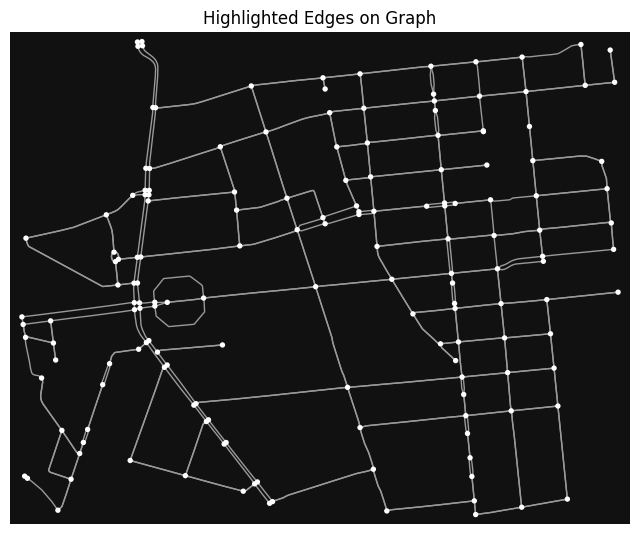

In [ ]:
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
from shapely.geometry import LineString

# Function to get the geometry of an edge
def get_edge_geometry(graph, u, v, key):
    if 'geometry' in graph[u][v][key]:
        return graph[u][v][key]['geometry']
    else:
        # Create a straight line if no geometry is present
        return LineString([(graph.nodes[u]['x'], graph.nodes[u]['y']),
                           (graph.nodes[v]['x'], graph.nodes[v]['y'])])

# Plot the graph with highlighted edges
def plot_paths(graph, edges, color_x):
    fig, ax = ox.plot_graph(graph, show=False, close=False)

    for edge in edges:
        if edge is not None:
            u, v, key = edge
            edge_geom = get_edge_geometry(graph, u, v, key)
            ax.plot(edge_geom.xy[0], edge_geom.xy[1], color=color_x, alpha=0.7, linewidth=2)

    plt.title('Highlighted Edges on Graph')
    plt.show()

# Plot the graph and highlight the edges from test_data
plot_paths(G, edge_tuples, 'blue')
